# Lesson7 ニューラルネットでゲームを攻略するAIをつくろう

## 目次

- Section 1 解説
    - 1.1 強化学習とは
    - 1.2 強化学習の定式化
    - 1.3 Temporal Difference (TD) 学習
    - 1.4 Q学習
    - 1.5 Deep Q学習
    - 1.6 Checkクイズ
- Section 2 実装①
    - 2.1 OpenAI Gymについて
    - 2.2 Colab上でのレンダリングについて
    - 2.3 DQNでCartPole
- Section 3 テクニック・発展的内容
    - 3.1 Prioritized Experience Replay
    - 3.2 Double DQN
    - 3.3 Dueling Network
    - 3.4 Checkクイズ
- Section 4 実装②
    - 4.1 DQN + テクニックでBreakout
- Section 5 ケーススタディ

### Checkクイズの解答
問1: ①,  問2: ②,  問3: ①

## Section 2 実装①

In [1]:
import os

import gym
import numpy as np

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input, Conv2D, Flatten
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.utils import to_categorical

### 2.1 OpenAI Gymについて

OpenAI GymとはOpenAIが開発している強化学習研究・開発のためのプラットフォームです。 CartpoleやAtariのゲームなどが簡単に利用できるようになっています。

使う流れとしては、

1. `gym.make('ゲームの名前')`: 環境を構築
2. `env.reset()`: エピソードを開始
3. `next_state, reward, terminal, _ = env.step(action)`: 行動を環境に渡し、 新しい状態, 報酬, episodeが終わったかどうかのフラグを受け取る。

となります。 また、 `env.render()`を実行することでゲームの途中の経過を確認することができます。

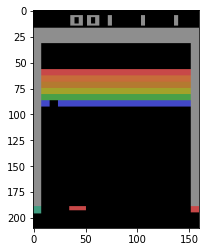

In [2]:
%matplotlib inline

import gym
import matplotlib.pyplot as plt
from IPython import display

env = gym.make('Breakout-v0') # ゲーム環境の構築

for episode in range(1):
    state = env.reset()
    terminal = False
    
    # Plot (説明の便宜上のもの)
    img = plt.imshow(state)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    while not terminal:
#         env.render() # ゲーム画面の出力

        action = env.action_space.sample() # とりあえず行動をランダムに選択
        next_state, reward, terminal, _ = env.step(action) # 行動を環境に渡し、 新しい状態, 報酬, エピソードが終わったかのフラグを受け取る
        
        # Plot (説明の便宜上のもの)
        img.set_data(next_state)
        display.display(plt.gcf())
        display.clear_output(wait=True)

### 2.2 Colab上でのレンダリングについて

ローカルPCなどでは`env.render()`を実行することにより新しいwindowが出てきて特に苦労なく出力を確認することができますが、   
Google Colaboratory（以下Colab）上で出力を確認する場合には`env.render()`が使えないため、以下を実行する必要があります。  
（※非公式の方法のため正しく動作しない場合があります。）

In [3]:
# Colab上では以下を実行してください
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [4]:
#Colab上では以下を実行してください
from pyvirtualdisplay import Display
pydisplay = Display(visible=0, size=(400, 300))
pydisplay.start()

### 2.3 DQNでCartpole \[[link\]](https://github.com/openai/gym/wiki/CartPole-v0)

強化学習のトイタスクとしてよく利用されるのがCartpoleです。 台車に棒が縦に乗った状態で始まり、 倒れようとする棒を台車を左右に動かすことで倒れないように保つゲームです。

KeyboardInterrupt: ignored

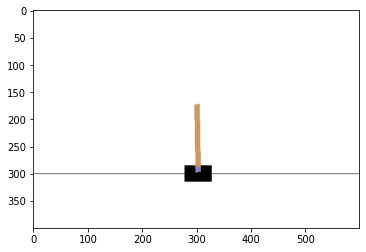

In [5]:
import gym
from IPython import display

env = gym.make('CartPole-v0') # ゲーム環境の構築
for episode in range(10):
    state = env.reset()
    terminal = False
    while not terminal:
        env.render() # ゲーム画面の出力

        action = env.action_space.sample() # 行動をランダムに選択
        next_state, reward, terminal, _ = env.step(action) # 行動を実行し、 次の状態、 報酬、 終端か否かの情報を取得
        
        ######Colab上で画面を出力するには以下を実行してください
        screen = env.render(mode='rgb_array')

        plt.imshow(screen)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        ######
env.close()

状態、 行動などは以下のようになっています。

- state: サイズ`(4,)`の`np.ndarary`
    - `(カートの位置, カートの速度, ポールの角度, ポールの角速度)`
- action
    - 0: カートを左に移動させる
    - 1: カートを右に移動させる
- reward
    - (常に) 1.0
- terminal
    - False: エピソード継続
    - True: エピソード終了（ポールが倒れた）

In [6]:
#Colab上では以下を実行してください
pydisplay.stop()

#### 2.3.1 各構成要素の実装

状態は4次元ベクトル、 行動の候補数は2つなので、 4->10->2ユニットをもつMLPを実装します。

In [7]:
def build_mlp():
    model = Sequential()
    
    model.add(Dense(10, activation='relu', input_shape=(4,)))
    model.add(Dense(2))
    
    model.compile(RMSprop(), 'mse')
    
    return model

Experience Replayを実現するために、 エージェントが経験した履歴を保存するクラスを実装します。

In [8]:
class ReplayMemory:
    def __init__(self, memory_size):
        self.memory_size = memory_size
        self.memory = []
    
    def __len__(self):
        return len(self.memory)
    
    def append(self, transition):
        self.memory.append(transition)
        self.memory = self.memory[-self.memory_size:]
    
    def sample(self, batch_size):
        batch_indexes = np.random.randint(0, len(self.memory), size=batch_size).tolist()

        state      = np.array([self.memory[index]['state'] for index in batch_indexes])
        next_state = np.array([self.memory[index]['next_state'] for index in batch_indexes])
        reward     = np.array([self.memory[index]['reward'] for index in batch_indexes])
        action     = np.array([self.memory[index]['action'] for index in batch_indexes])
        terminal   = np.array([self.memory[index]['terminal'] for index in batch_indexes])
        
        return {'state': state, 'next_state': next_state, 'reward': reward, 'action': action, 'terminal': terminal}

Target Networkを実現するために、 ネットワークの重みをコピーする関数を実装します。

In [9]:
def copy_weights(model_original, model_target):
    for i, layer in enumerate(model_original.layers):
        model_target.layers[i].set_weights(layer.get_weights())
    return model_target

#### 2.3.2 Replay Memoryへの貯蓄

学習の初めはReplay Memoryが空で思い出すものが何もないため、 学習を始める前にランダムに行動した履歴をメモリに事前にためておきます。

In [10]:
memory_size = 10**6 # 10**6
initial_memory_size = 5000 # 50000
n_actions = 2

In [11]:
env = gym.make('CartPole-v0')

replay_memory = ReplayMemory(memory_size)

step = 0

while True:
    state = env.reset()
    terminal = False
    
    while not terminal:
        action = np.random.randint(0, n_actions)
        
        next_state, reward, terminal, _ = env.step(action)
        reward = np.sign(reward)
        
        transition = {
            'state': state,
            'next_state': next_state,
            'reward': reward,
            'action': action,
            'terminal': int(terminal)
        }
        replay_memory.append(transition)

        state = next_state
        
        step += 1
        
        if (step + 1) % 10000 == 0:
            print('Number of frames:', step + 1)
    
    if step >= initial_memory_size:
        break

#### 2.3.3 学習

ネットワークの構築

In [12]:
model = build_mlp()
model_target = build_mlp()

eps_start = 1.0
eps_end = 0.1
n_steps = 1000

gamma = 0.99
target_update_interval = 1000

batch_size = 32

def get_eps(step):
    return max(0.1, (eps_end - eps_start)/n_steps * step + eps_start)

n_episodes = 500

def create_target(y, _t, action, n_actions):
    one_hot = to_categorical(action, n_actions)
    t = (1 - one_hot) * y + one_hot * _t[:, None]
    
    return t

step = 0

In [13]:
def train(batch_size):
    batch = replay_memory.sample(batch_size)
    
    try:
        q = model.predict(batch['state'])
    except:
        from IPython.core.debugger import Pdb; Pdb().set_trace()
    q_target_next = model_target.predict(batch['next_state'])
    
    _t = batch['reward'] + (1 - batch['terminal']) * gamma * q_target_next.max(1)
    t = create_target(q, _t, batch['action'], n_actions)
    
    return model.fit(batch['state'], t, epochs=1, verbose=0)

In [14]:
for episode in range(n_episodes):
    state = env.reset()
    terminal = False
    
    total_reward = 0
    total_q_max = []
    while not terminal:
        q = model.predict(state[None]).flatten()
        total_q_max.append(np.max(q))
        
        eps = get_eps(step)
        if np.random.random() < eps:
            action = np.random.randint(0, n_actions)
        else:
            action = np.argmax(q)
        next_state, reward, terminal, _ = env.step(action)
        reward = np.sign(reward)
        total_reward += reward
        
        transition = {
            'state': state,
            'next_state': next_state,
            'reward': reward,
            'action': action,
            'terminal': int(terminal)
        }
        replay_memory.append(transition)
        
        train(batch_size)
        
        state = next_state
        
        if (step + 1) % target_update_interval == 0:
            model_target = copy_weights(model, model_target)
        
        step += 1
        
    if (episode + 1) % 10 == 0:
        print('Episode: {}, Reward: {}, Q_max: {:.4f}, eps: {:.4f}'.format(episode + 1, total_reward, np.mean(total_q_max), eps))

Episode: 10, Reward: 22.0, Q_max: 0.7464, eps: 0.8281
Episode: 20, Reward: 31.0, Q_max: 1.0834, eps: 0.6940
Episode: 30, Reward: 13.0, Q_max: 1.0264, eps: 0.5590
Episode: 40, Reward: 10.0, Q_max: 1.2967, eps: 0.4213
Episode: 50, Reward: 16.0, Q_max: 1.3509, eps: 0.3124
Episode: 60, Reward: 17.0, Q_max: 1.2934, eps: 0.2143
Episode: 70, Reward: 10.0, Q_max: 1.4419, eps: 0.1297
Episode: 80, Reward: 12.0, Q_max: 1.8558, eps: 0.1000
Episode: 90, Reward: 9.0, Q_max: 2.2871, eps: 0.1000
Episode: 100, Reward: 13.0, Q_max: 2.2014, eps: 0.1000
Episode: 110, Reward: 10.0, Q_max: 2.3021, eps: 0.1000
Episode: 120, Reward: 13.0, Q_max: 2.2424, eps: 0.1000
Episode: 130, Reward: 11.0, Q_max: 2.1732, eps: 0.1000
Episode: 140, Reward: 10.0, Q_max: 2.3026, eps: 0.1000
Episode: 150, Reward: 9.0, Q_max: 2.2278, eps: 0.1000
Episode: 160, Reward: 10.0, Q_max: 2.2989, eps: 0.1000
Episode: 170, Reward: 9.0, Q_max: 2.4859, eps: 0.1000
Episode: 180, Reward: 11.0, Q_max: 3.1824, eps: 0.1000
Episode: 190, Reward: 

#### 2.3.4 テスト

学習させたモデルをテストしてみます。

In [15]:
def test():
    state = env.reset()
    terminal = False
    
    total_reward = 0
    while not terminal:
        #env.render()
        
        q = model.predict(state[None]).flatten()
        action = np.argmax(q)
        
        next_state, reward, terminal, _ = env.step(action)
        total_reward += reward
        
        state = next_state
    
    print(total_reward)

In [16]:
test()

13.0
